In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pickle

In [ ]:
# Load datasets
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
store = pd.read_csv('/content/store.csv')

# Merge train and test with store data
train = train.merge(store, on='Store', how='left')
test = test.merge(store, on='Store', how='left')

<ipython-input-13-4e80e7c72fea>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/train.csv')


In [ ]:

# Initial data inspection
print("Train Dataset Shape:", train.shape)
print("Test Dataset Shape:", test.shape)
print("\nTrain Columns:\n", train.columns)
print("\nSample Data:\n", train.head())


Train Dataset Shape: (1017209, 18)
Test Dataset Shape: (41088, 17)

Train Columns:
 Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

Sample Data:
    Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c      

In [ ]:

# Check missing values
print("\nMissing Values in Train Data:\n", train.isnull().sum())
print("\nMissing Values in Test Data:\n", test.isnull().sum())

# Fill missing values
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)


Missing Values in Train Data:
 Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

Missing Values in Test Data:
 Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                            11
Promo                            0
StateHoliday                     0
SchoolHoliday                  

In [ ]:
# Convert 'Date' to datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])


In [ ]:

# Extract date features
for df in [train, test]:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df.drop(columns=['Date'], inplace=True)


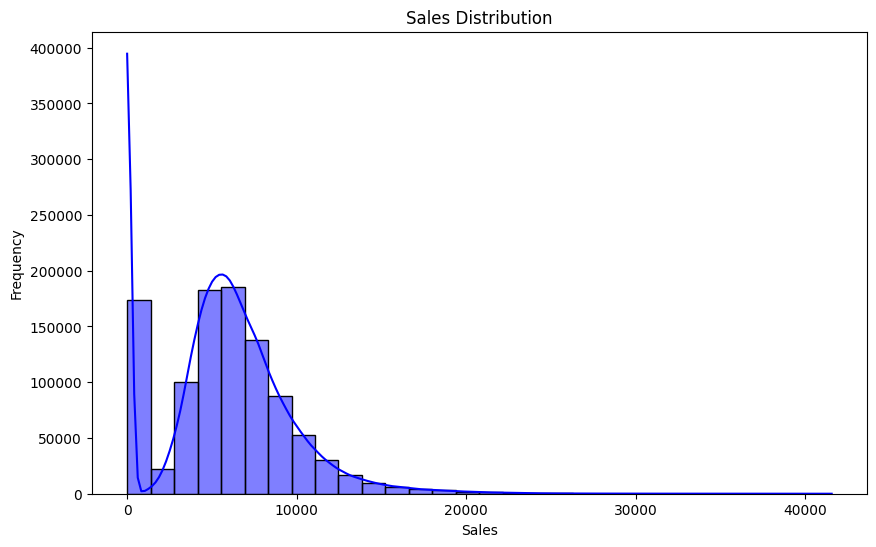

In [ ]:
# EDA: Distribution of Sales
plt.figure(figsize=(10, 6))
sns.histplot(train['Sales'], kde=True, bins=30, color='blue')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

<ipython-input-19-926e850cec23>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_sales_by_day.index, y=avg_sales_by_day.values, palette='viridis')


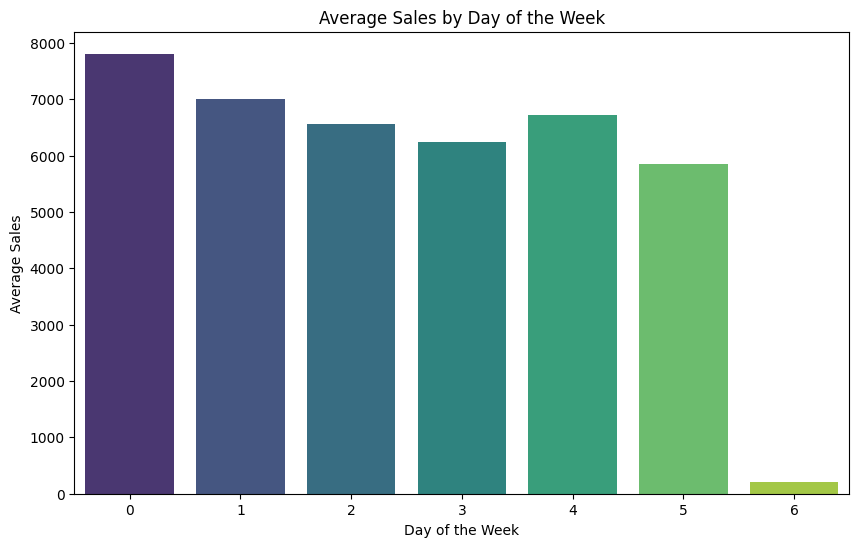

In [ ]:
# EDA: Average Sales by Day of the Week
plt.figure(figsize=(10, 6))
avg_sales_by_day = train.groupby('DayOfWeek')['Sales'].mean()
sns.barplot(x=avg_sales_by_day.index, y=avg_sales_by_day.values, palette='viridis')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.show()

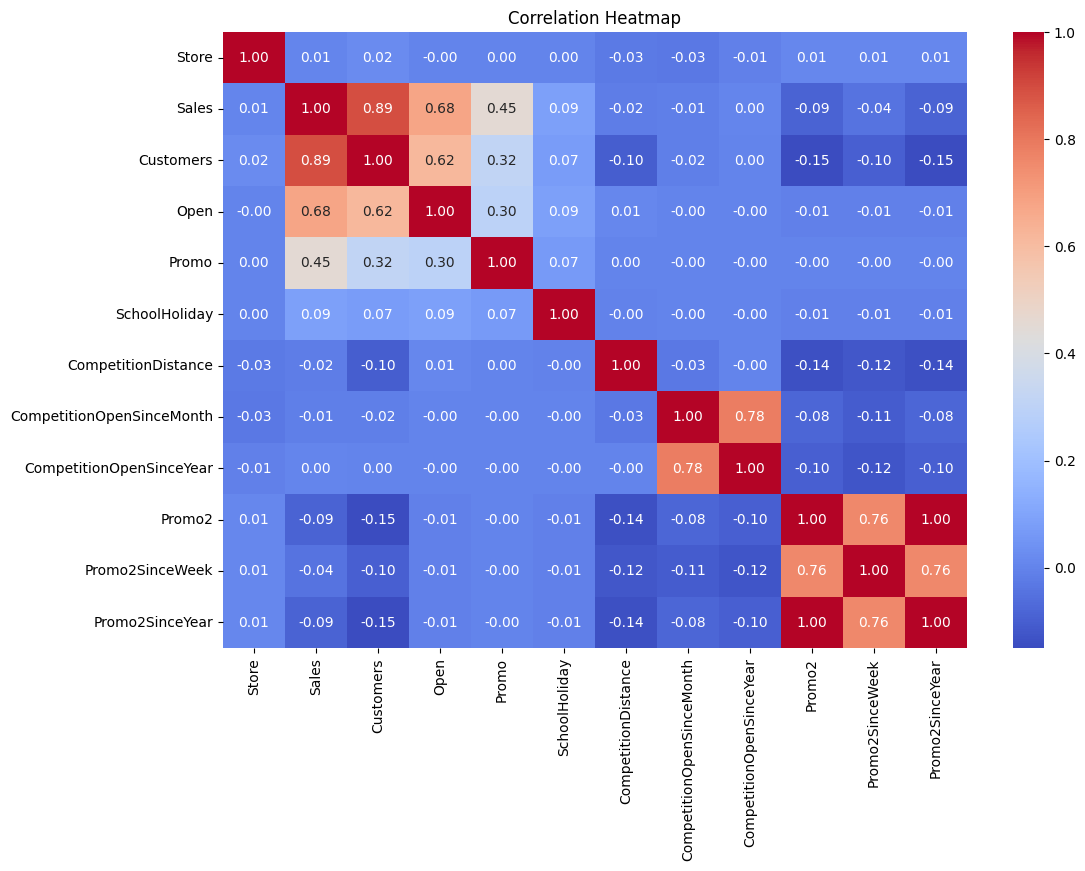

In [ ]:
# Select only numerical columns for correlation
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix
corr_matrix = train[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:

# Feature engineering: Encoding categorical variables
categorical_cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in categorical_cols:
    train[col] = train[col].astype('category').cat.codes
    test[col] = test[col].astype('category').cat.codes

# Define features and target
X = train.drop(columns=['Sales', 'Customers'])
y = train['Sales']

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# Model training: XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

print("\nTraining the XGBoost model...")
xgb_model.fit(X_train, y_train)


Training the XGBoost model...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Evaluate model
y_pred = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("\nValidation RMSE:", rmse)



Validation RMSE: 753.1130710879413


In [ ]:
from sklearn.metrics import r2_score

# Predict the values on the validation set
y_pred = xgb_model.predict(X_val)

# Calculate R-squared
r2 = r2_score(y_val, y_pred)
print(f"R-squared (R²): {r2:.4f}")


R-squared (R²): 0.9616


In [ ]:

# Save model
model_file = 'xgboost_rossmann.pkl'
with open(model_file, 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"\nModel saved to {model_file}")


Model saved to xgboost_rossmann.pkl


In [ ]:
# Predictions for test set
test['Sales'] = xgb_model.predict(test.drop(columns=['Id']))

# Save predictions to CSV
test[['Id', 'Sales']].to_csv('submission.csv', index=False)
print("\nPredictions saved to submission.csv")


Predictions saved to submission.csv


<Figure size 1000x600 with 0 Axes>

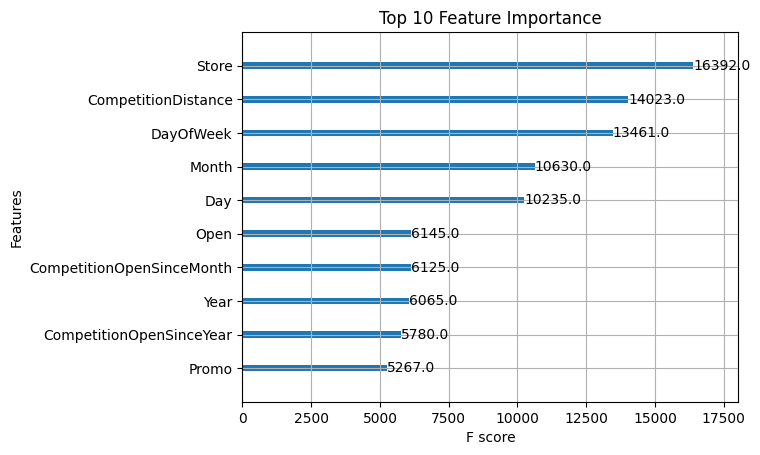

In [ ]:
# Feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title("Top 10 Feature Importance")
plt.show()

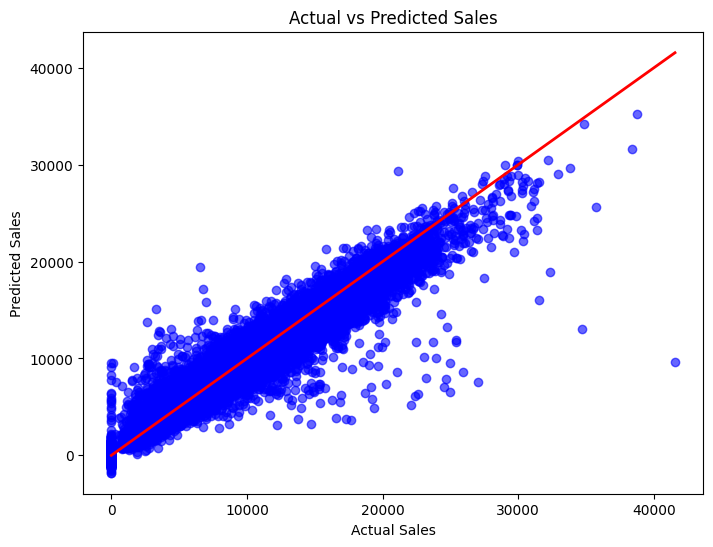

In [ ]:
import matplotlib.pyplot as plt

# Predict the values on the validation set
y_pred = xgb_model.predict(X_val)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linewidth=2)  # Ideal line (y=x)
plt.title("Actual vs Predicted Sales")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.show()


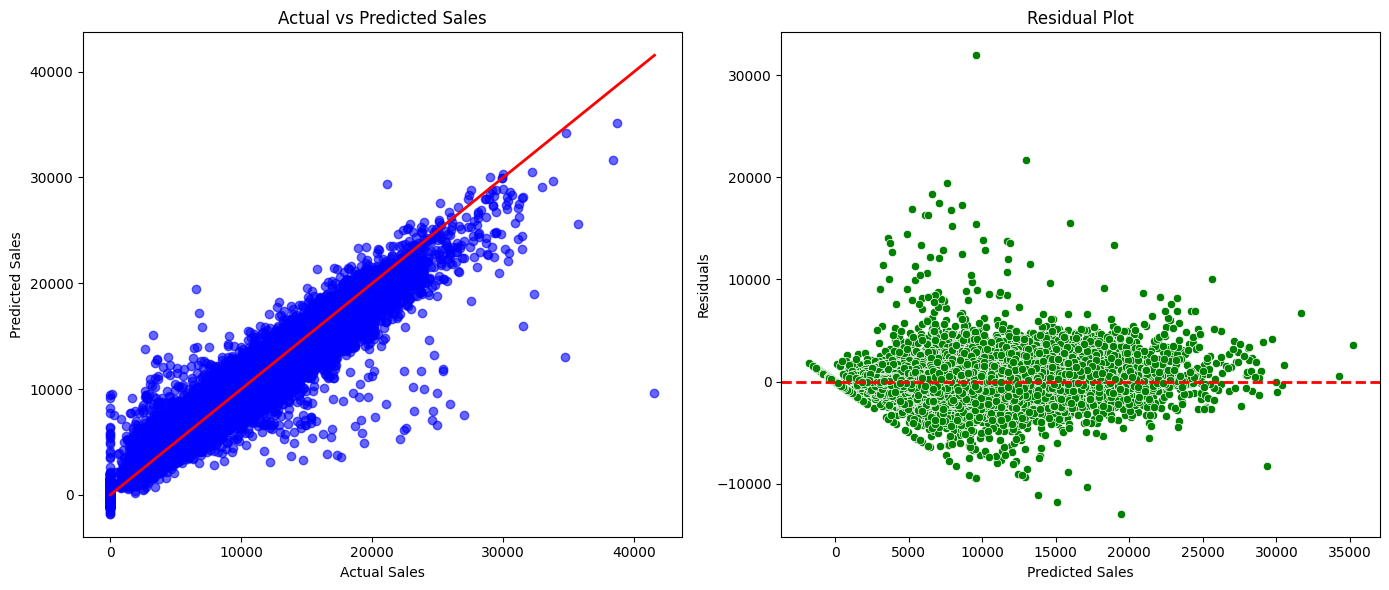

In [ ]:
import seaborn as sns

# Calculate residuals
residuals = y_val - y_pred

# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Scatter plot of actual vs predicted
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linewidth=2)  # Ideal line (y=x)
plt.title("Actual vs Predicted Sales")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")

# Subplot 2: Residual plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred, y=residuals, color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Zero error line
plt.title("Residual Plot")
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()
